In [29]:
# Code for Wyss Center ML Scientist task
# @ Gino Del Ferraro, NYU, June 2023

# Code number 3

In [56]:
# Show all jupyter outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [57]:
import numpy as np
np.set_printoptions(threshold=1000)

import os
import scipy
import sklearn
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns

import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import iirnotch, lfilter
from scipy.io import loadmat

import scipy.signal as sig
import scipy.stats.distributions as dist

In [58]:
## Change folder path to load data 

In [59]:
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
folder_path = os.path.join(parent_dir, 'Data')
os.chdir(folder_path)

In [60]:
# Load .mat file
R_spec = loadmat('Rspec_sess0_ch_split_ord.mat')
M1_spec = loadmat('M1spec_sess0_ch_split_ord.mat')
M2_spec = loadmat('M2spec_sess0_ch_split_ord.mat')

# Extract the 3D matrix from the mat_contents
R_sess0 = R_spec['spec']
M1_sess0 = M1_spec['spec']
M2_sess0 = M2_spec['spec']

print('sess 0')

R_sess0.shape
M1_sess0.shape
M2_sess0.shape

# Load .mat file
R_spec = loadmat('Rspec_sess1_ch_split_ord.mat')
M1_spec = loadmat('M1spec_sess1_ch_split_ord.mat')
M2_spec = loadmat('M2spec_sess1_ch_split_ord.mat')

# Extract the 3D matrix from the mat_contents
R_sess1 = R_spec['spec']
M1_sess1 = M1_spec['spec']
M2_sess1 = M2_spec['spec']

print('sess 1')

R_sess1.shape
M1_sess1.shape
M2_sess1.shape

# Load .mat file
R_spec = loadmat('Rspec_sess2_ch_split_ord.mat')
M1_spec = loadmat('M1spec_sess2_ch_split_ord.mat')
M2_spec = loadmat('M2spec_sess2_ch_split_ord.mat')

# Extract the 3D matrix from the mat_contents
R_sess2 = R_spec['spec']
M1_sess2 = M1_spec['spec']
M2_sess2 = M2_spec['spec']

print('sess 2')
R_sess2.shape
M1_sess2.shape
M2_sess2.shape

# Uncomment if you want to train on Sess 0 and 1 only, and test on Sess 2
# R = np.concatenate((R_sess0, R_sess1), axis=1)
# M1 = np.concatenate((M1_sess0, M1_sess1), axis=1)
# M2 = np.concatenate((M2_sess0, M2_sess1), axis=1)

# Comment out if you want to train on Sess 0 and 1 only, and test on Sess 2
R = np.concatenate((R_sess0, R_sess1, R_sess2), axis=1)
M1 = np.concatenate((M1_sess0, M1_sess1,M1_sess2), axis=1)
M2 = np.concatenate((M2_sess0, M2_sess1,M2_sess2), axis=1)

print('total')

print(R.shape)
print(M1.shape)
print(M2.shape)

sess 0


(6, 17, 450, 45)

(6, 14, 450, 45)

(6, 20, 450, 45)

sess 1


(6, 15, 450, 45)

(6, 16, 450, 45)

(6, 14, 450, 45)

sess 2


(6, 15, 450, 45)

(6, 18, 450, 45)

(6, 12, 450, 45)

total
(6, 47, 450, 45)
(6, 48, 450, 45)
(6, 46, 450, 45)


#### Take the log of the spectrogram (same thing done when visualizing results in matlab)


In [61]:
R = np.log(R)
M1 = np.log(M1)
M2 = np.log(M2)

R.shape
M1.shape
M2.shape

# # Uncomment if you want to train on Sess 0 and 1 only, and test on Sess 2
# R_sess2 = np.log(R_sess2)
# M1_sess2 = np.log(M1_sess2)
# M2_sess2 = np.log(M2_sess2)

# # Uncomment if you want to train on Sess 0 and 1 only, and test on Sess 2
# R_sess2.shape
# M1_sess2.shape
# M2_sess2.shape

(6, 47, 450, 45)

(6, 48, 450, 45)

(6, 46, 450, 45)

### Reorganize M1, M2 event into (ch, trial, first half/second half of 5 sec. long trial, time, frequency)
In order to avoid mixing first half/second half of Movement trials into the training/test set, I augment the dimension of the arrays by 1, and store the first/second half of the 5 sec trial into this dimension. Then I perform the train/test split followed by a reshaping of the movement arrays into the original shape.
#### Skip this cell and the following if training on Sess 0 and Sess 1 and testing on Sess 2. In that case go to point (##) below

In [62]:
M1x = M1.reshape(M1.shape[0], -1, 2, M1.shape[2], M1.shape[3])
M1x.shape
M2x = M2.reshape(M2.shape[0], -1, 2, M2.shape[2], M2.shape[3])
M2x.shape

(6, 24, 2, 450, 45)

(6, 23, 2, 450, 45)

#### Check reordering is correct. Note: "trial" can only be even

Skip this cell if training on Sess 0 and 1, testing on Sess 2

In [63]:
# Uncomment only if you want to check that the above cell returns what's expected
# ch = 1
# trial = 2 # only even numbers (even number is:first half, odd number is:second half)
# step = int(trial/2)
# M1[ch,trial,  1:10,1:10] - M1x[ch,step,0,  1:10,1:10]
# M1[ch,trial+1,  1:10,1:10] - M1x[ch,step,1,  1:10,1:10]

# M2[ch,trial,  1:10,1:10] - M2x[ch,step,0,  1:10,1:10]
# M2[ch,trial+1,  1:10,1:10] - M2x[ch,step,1,  1:10,1:10]

# Train-test split 

Skip this cell if training on Sess 0 and 1, testing on Sess 2

In [64]:
# Function to shuffle trials before train/test split (not of mandatory use)
def shuffle_trials(arr):

    num_trials = arr.shape[1]
    perm_trials = np.random.permutation(num_trials)
    arr_perm = arr[:, perm_trials, ...]
    
    return arr_perm

Skip this cell if training on Sess 0 and 1, testing on Sess 2

In [65]:
p = 0.82 # percentage of training data (Accuracy = 100%, for this value p = 0.82, which produces a 80/20 train/test split

th_r = round(R.shape[1]*p)
th_m1 = round(M1x.shape[1]*p)
th_m2 = round(M2x.shape[1]*p) 

# # You can uncomment this if you want to shuffle the arrays along the trial dim before splitting. 
# # (It is not mandatory, nor necessary, but it is something one may want to do.
# R = shuffle_trials(R)
# M1x = shuffle_trials(M1x)
# M2x = shuffle_trials(M2x)

train_r = R[:,:th_r]; test_r = R[:,th_r:]
train_m1x = M1x[:,:th_m1]; test_m1x = M1x[:,th_m1:]
train_m2x = M2x[:,:th_m2]; test_m2x = M2x[:,th_m2:]

train_r.shape, test_r.shape
train_m1x.shape, test_m1x.shape
train_m2x.shape, test_m2x.shape

print('\nBefore resampling:')
print(f'R test set rate: {round(test_r.shape[1]/train_r.shape[1],2)}')
print(f'M1 test set rate: {round(test_m1x.shape[1]/train_m1x.shape[1],2)}')
print(f'M2 test set rate: {round(test_m2x.shape[1]/train_m2x.shape[1],2)}')

((6, 39, 450, 45), (6, 8, 450, 45))

((6, 20, 2, 450, 45), (6, 4, 2, 450, 45))

((6, 19, 2, 450, 45), (6, 4, 2, 450, 45))


Before resampling:
R test set rate: 0.21
M1 test set rate: 0.2
M2 test set rate: 0.21


### Reshape into (ch, trial, time, frequency) after train/test split 

Skip this cell if training on Sess 0 and 1, testing on Sess 2

In [66]:
train_m1 = np.reshape(train_m1x, (train_m1x.shape[0], -1, train_m1x.shape[3], train_m1x.shape[4]))
train_m2 = np.reshape(train_m2x, (train_m2x.shape[0], -1, train_m2x.shape[3], train_m2x.shape[4]))

test_m1 = np.reshape(test_m1x, (test_m1x.shape[0], -1, test_m1x.shape[3], test_m1x.shape[4]))
test_m2 = np.reshape(test_m2x, (test_m2x.shape[0], -1, test_m2x.shape[3], test_m2x.shape[4]))

train_r.shape, test_r.shape
train_m1.shape, test_m1.shape
train_m2.shape, test_m2.shape

((6, 39, 450, 45), (6, 8, 450, 45))

((6, 40, 450, 45), (6, 8, 450, 45))

((6, 38, 450, 45), (6, 8, 450, 45))

In [67]:
p = 0.8 # percentage of training data 

th_r = int(R.shape[1]*p)
th_m1 = int(M1.shape[1]*p)
th_m2 = int(M2.shape[1]*p) 

train_r = R[:,:th_r]; test_r = R[:,th_r:]
train_m1 = M1[:,:th_m1]; test_m1 = M1[:,th_m1:]
train_m2 = M2[:,:th_m2]; test_m2 = M2[:,th_m2:]

th_r
th_m1
th_m2

37

38

36

### (##) Train on Sess 0 and 1, test on Sess 2. 
Uncomment the cell below if training on Sess 0 and 1, and testing on Sess 2

In [68]:
# # Uncomment if you want to train on Sess 0 and 1 only, and test on Sess 2
# train_r = R; test_r = R_sess2
# train_m1 = M1; test_m1 = M1_sess2
# train_m2 = M2; test_m2 = M2_sess2

# train_r.shape
# test_r.shape
# train_m1.shape
# test_m1.shape
# train_m2.shape
# test_m2.shape

### Oversample function for train test

In [69]:
import pdb
def oversample_train_set(*train_set):
    max_size = max(arr.shape[1] for arr in train_set)

    resampled_arrays = []
    for arr in train_set:
        ch, trial, time, freq = arr.shape
        if trial < max_size:
            # Create a list of indices to sample from
            indices = np.random.choice(trial, size=max_size, replace=True)
            # Resample the array along the trial dimension
            resampled_array = arr[:, indices, :, :]
        else:
            # If the array is already of maximum size, no need to resample
            resampled_array = arr
        resampled_arrays.append(resampled_array)

    return tuple(resampled_arrays)


### Train set - oversample

In [70]:
train_r, train_m1, train_m2 = oversample_train_set(train_r, train_m1, train_m2)
train_r.shape
train_m1.shape
train_m2.shape

(6, 38, 450, 45)

(6, 38, 450, 45)

(6, 38, 450, 45)

### Create labels for train and test set

In [71]:
def create_labels(R,M1,M2):
    
    len_R = R.shape[1]
    len_M1 = M1.shape[1]
    len_M2 = M2.shape[1]
    
    y = np.array([0] * len_R + [1] * len_M1 + [2] * len_M2)
    return y

In [82]:
# train set labels
y_train = create_labels(train_r,train_m1,train_m2)
y_train.shape
# test set labels
y_test = create_labels(test_r,test_m1,test_m2)
y_test.shape
# rate
round(y_test.shape[0]/(y_test.shape[0]+y_train.shape[0]),2)

(114,)

(30,)

0.21

### Train and Test set 

In [73]:
X_train = np.concatenate((train_r, train_m1, train_m2),axis=1)
X_test = np.concatenate((test_r, test_m1, test_m2),axis=1)

In [74]:
# train
X_train.shape
y_train.shape
# test
X_test.shape
y_test.shape

(6, 114, 450, 45)

(114,)

(6, 30, 450, 45)

(30,)

### Flatten array for SVM

In [75]:
# (trial, channel * time * frequency)
XR_train = np.reshape(X_train, (X_train.shape[1], -1))
XR_test = np.reshape(X_test, (X_test.shape[1], -1))
XR_train.shape
XR_test.shape
y_test.shape

(114, 121500)

(30, 121500)

(30,)

### Shuflle train and test

In [76]:
from sklearn.utils import shuffle

XR_train, y_train = shuffle(XR_train, y_train, random_state=42)
XR_test, y_test = shuffle(XR_test, y_test, random_state=42)
XR_test.shape, y_test.shape

((30, 121500), (30,))

### Normalize, rescale data

In [77]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(XR_train)

# Transform the training and test data
XS_train = scaler.transform(XR_train)
XS_test = scaler.transform(XR_test)

StandardScaler()

## TRAIN and TEST model

### SVM 

In [78]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


svm_classifier = svm.SVC(kernel='rbf')
svm_classifier.fit(XS_train, y_train)

# predictions on the test data
y_pred = svm_classifier.predict(XS_test)

# accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:{:.2f}".format(accuracy))


SVC()

Accuracy:1.00


In [79]:
def plot_confusion_matrix(y_true, y_pred, classes,normalize=False,title=''):

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix " + title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    return plt.gca()

# class labels
classes = ['Rest', 'M1', 'M2']

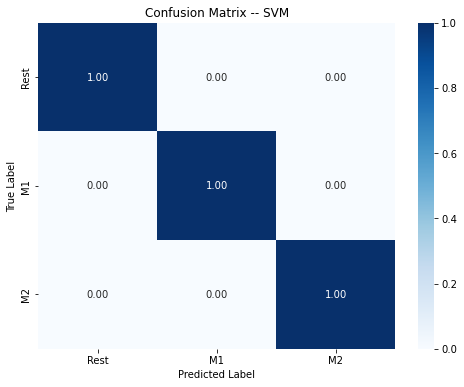

In [80]:
# Plot the confusion matrix
axes = plot_confusion_matrix(y_test, y_pred,classes,normalize=True,title='-- SVM')

### SVM classification report

In [81]:
# SVM
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define your MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Set the hyperparameters
input_size = XS_train.shape[1]  # Number of input features
hidden_size = 64  # Number of neurons in the hidden layer
num_classes = len(set(y_train))  # Number of output classes
dropout_rate = 0.3  # Dropout rate

# Create an instance of the MLP model
model = MLP(input_size, hidden_size, num_classes, dropout_rate)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert the data into PyTorch tensors
X_train_tensor = torch.Tensor(XS_train)
y_train_tensor = torch.LongTensor(y_train)

# Create a DataLoader for training data
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Train the MLP model
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Convert the test data into PyTorch tensors
X_test_tensor = torch.Tensor(XS_test)

# Make predictions on the test data
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    y_pred = predicted.numpy()

# Calculate the accuracy
accuracy = (y_pred == y_test).mean()
print("Accuracy:", accuracy)


In [ ]:
y_pred
y_test

In [ ]:
plot_confusion_matrix(y_test, y_pred,classes,normalize=False,title='-- MLP')

In [ ]:
# MLP
print (classification_report(y_test, y_pred))